In [116]:
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import seaborn as sns

from collections import Counter

from agglomerative import get_data

from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AffinityPropagation,DBSCAN,AgglomerativeClustering
from sklearn.metrics import silhouette_score

%matplotlib inline

In [50]:
# Constants - The master stat (feature) list, and the corresponding player data.
stats_list = ['MP_x','FG','FGA','2P','2PA','3P','3PA','FT','FTA','ORB', 'DRB', 'TRB', 'AST', 'STL','BLK','TOV','PF','PTS','FG%','2P%','3P%', 'eFG%', 'FT%', 'TS%_x', 'PER', '3PAr','FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%','ORtg', 'DRtg', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM','VORP', 'dist', 'spd', 'tchs', 'pass', 'sast', 'ftast', 'dfgm','dfga']
df = pd.read_csv('../data/final_stats.csv')
df.set_index('player_year',inplace=True)
df.fillna(value=0,inplace=True)

In [31]:
# A number of tools we'll use to help us analyze different feature spaces! 
def plot_tsne_scatter(X,filename=None,three_d=False,title=None):
    '''
    Arguments:
    X - Feature matrix X, a dataframe or array of numerical data.
    filename - String, appended to filename of png written to directory img
    three_d - Boolean, if True, function plots and saves 3-d representation of data as well.
    title - String, used as title of plot(s)

    Output:
    None, plots 2d-projection of higher-dimensional data, saves figure to img directory.
    '''
    tsne2d = TSNE(n_components=2,init='pca',random_state=23).fit_transform(X)
    tsne3d = TSNE(n_components=3,init='pca',random_state=23).fit_transform(X)


    fig = plt.figure(figsize=(6,4))
    ax1 = fig.add_subplot(111)
    ax1.scatter(tsne2d[:,0],tsne2d[:,1],cmap=plt.cm.Spectral)
    ax1.set_title(title)
    plt.axis('tight')
    plt.show()
    if not filename:
        plt.savefig('../img/2dtsne.png')
    else:
        plt.savefig('../img/2dtsne_{}.png'.format(filename))

    if three_d:
        ax2 = fig.add_subplot(111,projection='3d')
        ax2.scatter(tsne3d[:,0],tsne3d[:,1],tsne3d[:,2],cmap=plt.cm.Spectral)
        ax2.set_title(title)
        plt.axis('tight')
        if not filename:
            plt.savefig('../img/3dtsne.png')
        else:
            plt.savefig('../img/3dtsne_{}.png'.format(filename))

def tsne_silhouette_score(X,mod='KMeans'):
    '''
    Arguments:
    X - Feature matrix X
    mod - Default KMeans, the scikit-learn clustering model to use.
    
    Returns the resulting silhouette score of the clustering model on the feature space.
    '''
    tsne = TSNE(n_components=2,init='pca',random_state=23)
    tsne.fit(X)
    tsne_vectors = tsne.embedding_

    if mod == 'KMeans':
        model = KMeans(n_clusters=5) # 5 because 5 NBA positions, get it?!
    if mod == 'AffinityPropagation':
        model = AffinityPropagation()

    model.fit(tsne_vectors)

    return silhouette_score(tsne_vectors,model.labels_)

def randomize_feature_space(stats_list):
    '''
    Arguments: 
    stats_list - The entire feature space -- the list can be found at the top of this notebook! 
    
    Returns a randomized subset of the feature space, ranging from 10 to all 53.
    '''
    no_features = random.randint(10,53)
    features_index = random.sample(range(0,53),no_features)

    return [stats_list[x] for x in features_index]

def get_feature_spaces(n):
    '''
    Arguments:
    n - Integer, the number of sub-spaces the function returns
    
    Returns n randomized subsets of the feature space in a dictionary
    '''
    feature_space_dict = {}
    
    for i in range(4):
        potential_features = []
        max_vect = ([],0)
        for _ in range(500):
            new_stats = randomize_feature_space(stats_list)
            X, _ = get_data(df,new_stats)
            score = tsne_silhouette_score(X,mod='KMeans')
            potential_features.append((new_stats,score))
            if n % 25 == 0:
                print (n)
            n += 1

        potential_features.sort(key=lambda x: x[1])
        feature_space_dict[i] = potential_features[-1]
    return feature_space_dict

# Exploring Feature Sub-Spaces
I realized that there are surely a number of ways to cluster these players, so I want to play around with a number of subsets of my whole feature space.  My first move is to randomize a number of these subsets - say, 4 - and perform exploratory clustering analysis on them.  I achieve this primarily using t-SNE - t-distributed stochastic neighbor embedding - to visualize the data in two (or three) dimensions.  

In [47]:
# This line will run get_feature_spaces for n=4 - This will generate 500 random feature subspaces (4 times), and pull the  
# best performer (by silhouette score) from each set of 500.  Be careful about running this, it takes quite some time to run!

# get_feature_spaces(4)

# I've run this beforehand, and will simply use the lists it generated for me at that time.
spaces = {'fs1' : ['FG%', 'TOV', '3P%', 'DBPM', '3PA', 'BLK', 'STL', 'STL%', '2P%', 'dfgm', 'dfga', '3PAr', 'AST%', 'FT%'],
          'fs2' : ['DRtg', 'eFG%', 'pass', 'FT%', 'tchs', '3PA', 'STL', 'dfgm', '3PAr', 'TRB', 'BLK', 'OBPM', 'FT'],
          'fs3' : ['TRB%', 'DRB', '2P%', 'FGA', 'STL', 'AST%', 'FTr', '3P%', 'FT%', 'FT', 'dfgm', 'BLK', '3PAr'],
          'fs4' : ['FGA', '2PA', 'USG%', 'STL', 'dfgm', 'DRB%', 'OWS', 'BLK%', 'DWS', 'AST%', 'dfga', 'TRB', 'FG']
          }

In [33]:
# Let's do a simple count of the different stats:
count = dict(Counter(spaces['fs1']+spaces['fs2']+spaces['fs3']+spaces['fs4']))
print(count)

{'STL%': 1, 'dfgm': 4, 'FT': 2, 'tchs': 1, 'pass': 1, 'TOV': 1, 'dfga': 2, '2PA': 1, 'FG': 1, '3PA': 2, 'DRB': 1, 'OBPM': 1, 'DBPM': 1, 'FT%': 3, 'BLK%': 1, '3PAr': 3, 'FGA': 2, 'OWS': 1, 'DWS': 1, 'STL': 4, 'TRB': 2, 'AST%': 3, 'eFG%': 1, 'BLK': 3, 'FG%': 1, 'FTr': 1, 'USG%': 1, 'DRtg': 1, '2P%': 2, 'DRB%': 1, 'TRB%': 1, '3P%': 2}


In [34]:
# And a check for which stats didn't make it:
for stat in stats_list:
    if stat not in count.keys():
        print(stat)

MP_x
2P
3P
FTA
ORB
AST
PF
PTS
TS%_x
PER
ORB%
TOV%
ORtg
WS
WS/48
BPM
VORP
dist
spd
sast
ftast


### A lot of these make sense!

A number of these (TS%, PER, ORtg, WS, WS/48, BPM, and VORP) are ensemble stats which say less about what a player does in a specific area, than they do about a player's overall contribution.

### Let's Look at these Feature Spaces

Feature Space No. 1
Feature Space No. 2
Feature Space No. 3
Feature Space No. 4


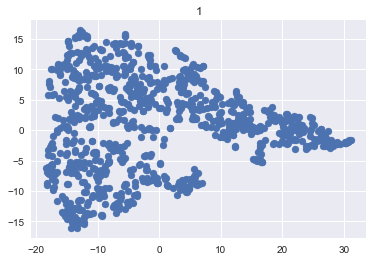

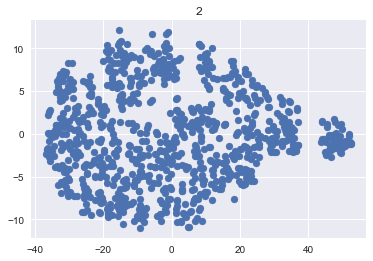

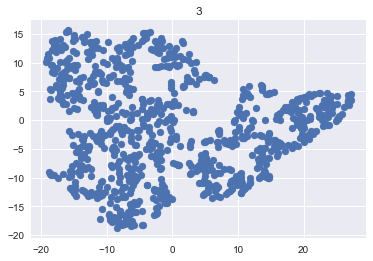

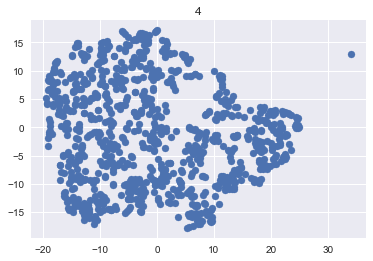

In [51]:
for key in spaces.keys():
    X = df[spaces[key]]
    print ('Feature Space No. {}'.format(key[2]))
    plot_tsne_scatter(X,filename='feature_space_{}'.format(key[2]),title=key[2])
    

Each of those spaces definitely feature some good-looking clusters! Number two looks the best to me - let's explore it a little deeper:

In [69]:
X = df[spaces['fs2']]
X.columns

Index([u'DRtg', u'eFG%', u'pass', u'FT%', u'tchs', u'3PA', u'STL', u'dfgm',
       u'3PAr', u'TRB', u'BLK', u'OBPM', u'FT'],
      dtype='object')

Let's look at some pairwise plots for these features:

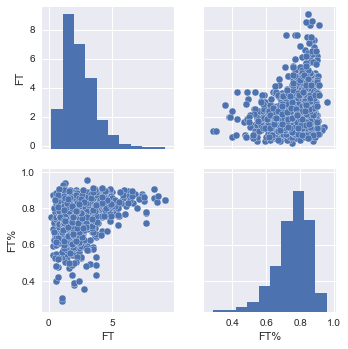

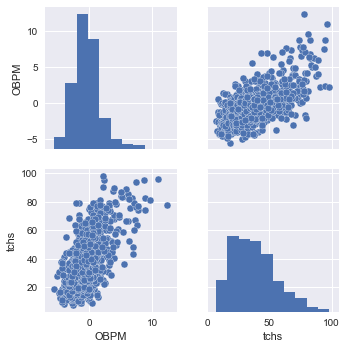

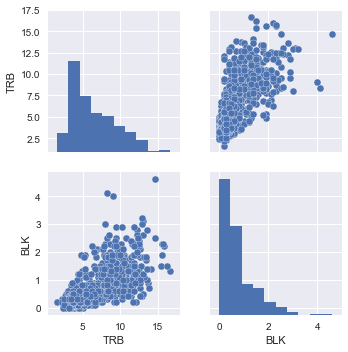

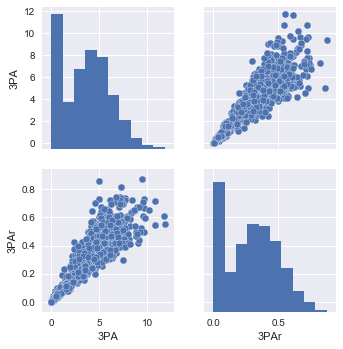

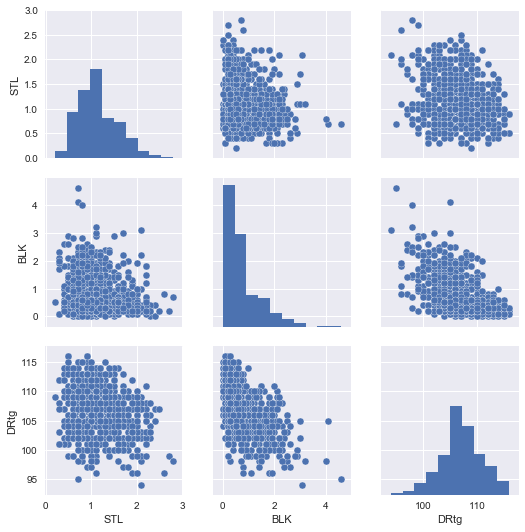

In [79]:
# Do any features seem like they might be collinear...?
sns.pairplot(X[['FT','FT%']])
sns.pairplot(X[['OBPM','tchs']])
sns.pairplot(X[['TRB','BLK']])
sns.pairplot(X[['3PA','3PAr']])
sns.pairplot(X[['STL','BLK','DRtg']])

## Let's try some simple clustering techniques on our subspaces!

In [83]:
damping_list = np.linspace(0.5,0.99,10)
def cluster(X):
    for d in damping_list:
        affinity = AffinityPropagation(damping=d)
        affinity.fit(X)
        try:
            print('{} | {}'.format(d,silhouette_score(X,affinity.labels_)))
        except:
            continue
for space in spaces.keys():
    print(space)
    X = df[spaces[space]]
    cluster(X)
    print('---')

fs1
0.5 | 0.18559179087
0.554444444444 | 0.192571657695
0.608888888889 | 0.182586785646
0.663333333333 | 0.188425446411
0.717777777778 | 0.187947340317
0.772222222222 | 0.188435979657
0.826666666667 | 0.186108279625
0.881111111111 | 0.185127771024
0.935555555556 | 0.185127771024
0.99 | 0.195580338154
---
fs2
0.5 | 0.170276401652
0.554444444444 | 0.176406449527
0.608888888889 | 0.176679300389
0.663333333333 | 0.171206775794
0.717777777778 | 0.170028012277
0.772222222222 | 0.171055809568
0.826666666667 | 0.172985513738
0.881111111111 | 0.172985513738
0.935555555556 | 0.169553743425
0.99 | 0.497763549247
---
fs3
0.5 | 0.201130080014
0.554444444444 | 0.20263834463
0.608888888889 | 0.19906555986
0.663333333333 | 0.203194460022
0.717777777778 | 0.201542173315
0.772222222222 | 0.196603495232
0.826666666667 | 0.201241519808
0.881111111111 | 0.202919039059
0.935555555556 | 0.199883642262
0.99 | 0.328149557039
---
fs4
0.5 | 0.16364651303
0.554444444444 | 0.16348328647
0.608888888889 | 0.15968404

That silhouette spike in fs2 with damping = 0.99 seems worth checking out...

In [99]:
affinity = AffinityPropagation(damping=0.99)
X = df[spaces['fs2']]
affinity.fit(X)
X['label'] = affinity.labels_

/Users/robertcorboy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [100]:
# Let's see the distribution of our cluster labels:
X['label'].value_counts()

0    549
1    362
Name: label, dtype: int64

In [102]:
# That's...not quite what we were looking for.  Let's try something similar but only keep the models that meet  
# a certain condition

damping_list = np.linspace(0.5,0.99,10)
def cluster_exclusive(X):
    for d in damping_list:
        affinity = AffinityPropagation(damping=d)
        affinity.fit(X)
        X['label'] = affinity.labels_
        if X.loc['Nikola Jokic/2016-17']['label'] == X.loc['Marc Gasol/2016-17']['label']:
            print('{} | {}'.format(d,len(X['label'].value_counts())))
for space in spaces.keys():
    print(space)
    X = df[spaces[space]]
    cluster_exclusive(X)
    print('---')
    
# This snippet iterates through each feature subspace, and fits the space, iteratively, with various affinity
# propagation models.  It will print a damping parameter in a given subspace only if Nikola Jokic and Marc Gasol 
# are placed in the same cluster.  These are two very similar players, and this is a nice way of checking if a model 
# is working at least a little bit

fs1


/Users/robertcorboy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.5 | 35
0.554444444444 | 31
0.608888888889 | 30
0.663333333333 | 29
0.717777777778 | 29
0.772222222222 | 30
0.826666666667 | 30
0.881111111111 | 29
0.935555555556 | 29
0.99 | 3
---
fs2
0.5 | 27
0.554444444444 | 27
0.608888888889 | 27
0.663333333333 | 27
0.717777777778 | 27
0.772222222222 | 27
0.826666666667 | 28
0.881111111111 | 28
0.935555555556 | 28
---
fs3
0.5 | 38
0.554444444444 | 36
0.608888888889 | 36
0.663333333333 | 35
0.717777777778 | 35
0.772222222222 | 35
0.826666666667 | 35
0.881111111111 | 34
0.935555555556 | 34
0.99 | 1
---
fs4
0.5 | 43
0.554444444444 | 40
0.608888888889 | 40
0.663333333333 | 40
0.717777777778 | 40
0.772222222222 | 40
0.826666666667 | 40
0.881111111111 | 39
0.935555555556 | 39
---


Those all look like pretty high cluster counts, let's try another unsupervised method - DBSCAN:

In [108]:
eps_list = np.linspace(0.5,5,15)
def cluster_dbscan(X):
    for epsilon in eps_list:
        db = DBSCAN(eps=epsilon)
        db.fit(X)
        X['label'] = db.labels_
        if X.loc['Nikola Jokic/2016-17']['label'] == X.loc['Marc Gasol/2016-17']['label']:
            print('{} || {}'.format(epsilon,len(X['label'].value_counts())))
for space in spaces.keys():
    print(space)
    X = df[spaces[space]]
    cluster_dbscan(X)
    print('---')

fs1


/Users/robertcorboy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.5 || 1
0.821428571429 || 1
1.14285714286 || 8
1.46428571429 || 28
1.78571428571 || 35
2.10714285714 || 41
2.42857142857 || 44
2.75 || 45
5.0 || 3
---
fs2
0.5 || 1
0.821428571429 || 1
1.14285714286 || 1
1.46428571429 || 1
1.78571428571 || 1
2.10714285714 || 1
2.42857142857 || 6
2.75 || 10
3.07142857143 || 20
3.39285714286 || 34
3.71428571429 || 44
4.03571428571 || 49
---
fs3
0.5 || 1
0.821428571429 || 1
1.14285714286 || 3
1.46428571429 || 17
1.78571428571 || 28
2.10714285714 || 38
2.42857142857 || 50
2.75 || 52
3.07142857143 || 54
3.39285714286 || 53
3.71428571429 || 43
4.03571428571 || 33
4.35714285714 || 21
4.67857142857 || 11
---
fs4
0.5 || 1
0.821428571429 || 1
1.14285714286 || 1
1.46428571429 || 1
1.78571428571 || 1
2.10714285714 || 2
2.42857142857 || 7
2.75 || 12
3.07142857143 || 17
3.39285714286 || 24
3.71428571429 || 27
4.03571428571 || 31
4.35714285714 || 27
4.67857142857 || 25
5.0 || 17
---


For each of our subspaces, it looks like we can roughly control our number of clusters by keeping the epsilon value in a certain range...let's customize those ranges, and see what our clusters end up looking like:

In [110]:
fs1_eps = np.linspace(1.15,1.4,8)
fs2_eps = np.linspace(2.75,3.1,8)
fs3_eps = np.linspace(1.4,1.7,8)
fs4_eps = np.linspace(3,3.2,8)

eps_dict = {'fs1':fs1_eps,'fs2':fs2_eps,'fs3':fs3_eps,'fs4':fs4_eps}

eps_list = np.linspace(0.5,5,15)
def cluster_scan_interval(X,eps_list):
    for epsilon in eps_list:
        db = DBSCAN(eps=epsilon)
        db.fit(X)
        X['label'] = db.labels_
        if X.loc['Nikola Jokic/2016-17']['label'] == X.loc['Marc Gasol/2016-17']['label']:
            print('{} || {} || Silhouette Score: {}'.format(epsilon,len(X['label'].value_counts()),silhouette_score(X,db.labels_)))
for space in spaces.keys():
    print(space)
    X = df[spaces[space]]
    eps_list = eps_dict[space]
    cluster_scan_interval(X,eps_list)
    print('---')

fs1


/Users/robertcorboy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1.15 || 8 || Silhouette Score: -0.407433510315
1.18571428571 || 10 || Silhouette Score: -0.349584108699
1.22142857143 || 11 || Silhouette Score: -0.331029087101
1.25714285714 || 15 || Silhouette Score: -0.286278534275
1.29285714286 || 17 || Silhouette Score: -0.277823784557
1.32857142857 || 24 || Silhouette Score: -0.214877664672
1.36428571429 || 27 || Silhouette Score: -0.218971590429
1.4 || 30 || Silhouette Score: -0.177794760676
---
fs2
2.75 || 9 || Silhouette Score: -0.396378927474
2.8 || 9 || Silhouette Score: -0.398460418135
2.85 || 10 || Silhouette Score: -0.393973828623
2.9 || 12 || Silhouette Score: -0.445878394967
2.95 || 17 || Silhouette Score: -0.376397300318
3.0 || 18 || Silhouette Score: -0.371264761585
3.05 || 18 || Silhouette Score: -0.371264761585
3.1 || 22 || Silhouette Score: -0.356097318188
---
fs3
1.4 || 11 || Silhouette Score: -0.314601760589
1.44285714286 || 15 || Silhouette Score: -0.321421933909
1.48571428571 || 16 || Silhouette Score: -0.327416257811
1.5285714

Those silhouette scores are notably poor, let's see how the clusters look on the basketball side of things...

In [114]:
# We'll use fs2 as an example again - with epsilon=2.92
db = DBSCAN(eps=2.92)
X = df[spaces['fs2']]
db.fit(X)
X['label'] = db.labels_
X.head()

/Users/robertcorboy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


DRtg   eFG%      pass    FT%       tchs  3PA  STL  \
player_year                                                                  
Nick Collison/2015-16     107  0.459  5.744681  0.697   7.333333  0.1  0.8   
Jimmer Fredette/2014-15   111  0.407  5.918605  0.956   8.779070  3.4  1.1   
Brandon Bass/2016-17      109  0.578  7.147727  0.875  10.397727  0.2  0.9   
Tyler Zeller/2016-17      109  0.494  7.863636  0.564  10.795455  0.1  0.5   
Justin Holiday/2014-15    101  0.462  5.940594  0.822   8.861386  6.0  2.2   

                             dfgm   3PAr  TRB  BLK  OBPM   FT  label  
player_year                                                           
Nick Collison/2015-16    0.468085  0.018  8.8  0.8  -2.5  1.2     -1  
Jimmer Fredette/2014-15  0.127907  0.289  2.8  0.1  -2.6  3.0     -1  
Brandon Bass/2016-17     0.420455  0.016  8.0  0.7   0.1  4.8     -1  
Tyler Zeller/2016-17     0.772727  0.006  8.5  1.4  -3.2  1.5     -1  
Justin Holiday/2014-15   0.247525  0.464  4.0  0.7  -1.4  2.0     -1

In [115]:
X['label'].value_counts()

-1    781
 0     55
 3     24
 2     15
 9      7
 1      6
 4      6
 8      5
 5      5
 6      4
 7      3
Name: label, dtype: int64

Uh Oh... -1 means a record is too noisy for DBSCAN to label - let's move on to something else.

In [122]:
# Agglomerative Clustering
# In agglomerative clustering, at the beginning of runtime, each record constitutes a cluster; the algorithm then 
# iteratively merges pairs of clusters until arriving at a specified k clusters.

cluster_list = range(5,20)
def cluster_agglomerative(X,cluster_list):
    for k in cluster_list:
        agg = AgglomerativeClustering(n_clusters=k,affinity='cosine',linkage='average')
        agg.fit(X)
        X['label'] = agg.labels_
        if X.loc['Nikola Jokic/2016-17']['label'] == X.loc['Marc Gasol/2016-17']['label']:
            print('{} clusters || Silhouette Score: {}'.format(k,silhouette_score(X,agg.labels_)))
for space in spaces.keys():
    print(space)
    X = df[spaces[space]]
    cluster_agglomerative(X,cluster_list)
    print('---')

fs1


/Users/robertcorboy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


5 clusters || Silhouette Score: 0.00233293011511
6 clusters || Silhouette Score: -0.011039270186
7 clusters || Silhouette Score: -0.00307478155147
8 clusters || Silhouette Score: -0.00322161906276
9 clusters || Silhouette Score: 0.112764843027
10 clusters || Silhouette Score: 0.0504255183163
11 clusters || Silhouette Score: 0.121318062622
12 clusters || Silhouette Score: 0.103915665786
13 clusters || Silhouette Score: 0.166352330233
14 clusters || Silhouette Score: 0.140229108639
15 clusters || Silhouette Score: 0.108901825203
16 clusters || Silhouette Score: 0.135450653771
17 clusters || Silhouette Score: 0.155460672484
18 clusters || Silhouette Score: 0.110293127295
19 clusters || Silhouette Score: 0.214322129259
---
fs2
5 clusters || Silhouette Score: 0.29969339033
6 clusters || Silhouette Score: 0.277395851916
7 clusters || Silhouette Score: 0.271470611371
8 clusters || Silhouette Score: 0.275283634007
9 clusters || Silhouette Score: 0.282226945108
10 clusters || Silhouette Score: 

## A Couple Things to Notice:
1. The 3rd and 4th feature spaces only managed to place Jokic and Gasol in the same cluster once - those both warrant further investigation, but that's perhaps a sign that a final space looking more like some combination of feature spaces 1 and 2 will give us the clusters we're looking for.
  
2. Barring the n_clusters parameter, these scores came from largely out-of-box modelling - there's plenty of room for improvement!

3. While scores held fairly constant through the entirety of fs2's iteration, they didn't jump above 0.1 on fs1 until k > 10, perhaps an indicator that we should be looking for a similar number of clusters.

With number 3 in mind, let's try some more algorithms, starting with K-Means:

In [125]:
# Let's look exclusively for models that will outperform what we've already seen agglomerative clustering do

cluster_list = range(5,20)
def cluster_kmeans(X,cluster_list):
    for k in cluster_list:
        km = KMeans(n_clusters=k,max_iter=500,algorithm='full',precompute_distances=True)
        km.fit(X)
        X['label'] = km.labels_
        if silhouette_score(X,km.labels_) > 0.2 and X.loc['Nikola Jokic/2016-17']['label'] == X.loc['Marc Gasol/2016-17']['label']:
            print('{} clusters || Silhouette Score: {}'.format(k,silhouette_score(X,km.labels_)))
for space in spaces.keys():
    print(space)
    X = df[spaces[space]]
    cluster_kmeans(X,cluster_list)
    print('---')

fs1


/Users/robertcorboy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


5 clusters || Silhouette Score: 0.358382833744
6 clusters || Silhouette Score: 0.366664993969
10 clusters || Silhouette Score: 0.422942280235
11 clusters || Silhouette Score: 0.369830908301
12 clusters || Silhouette Score: 0.359236192954
13 clusters || Silhouette Score: 0.403639986858
14 clusters || Silhouette Score: 0.401916918912
15 clusters || Silhouette Score: 0.422962011563
16 clusters || Silhouette Score: 0.411985657462
17 clusters || Silhouette Score: 0.41006260698
18 clusters || Silhouette Score: 0.437356367015
19 clusters || Silhouette Score: 0.408000023944
---
fs2
5 clusters || Silhouette Score: 0.330871144693
6 clusters || Silhouette Score: 0.317021659894
7 clusters || Silhouette Score: 0.280733439711
8 clusters || Silhouette Score: 0.28656066641
9 clusters || Silhouette Score: 0.290901248724
10 clusters || Silhouette Score: 0.294368028273
11 clusters || Silhouette Score: 0.303957946238
12 clusters || Silhouette Score: 0.319255152838
13 clusters || Silhouette Score: 0.276160

fs1 did pretty well with very little parameterization, let's dig into it a little bit:

In [127]:
# let's fit the model 1000 times, and see which number of clusters ends up giving us the best scores

# caution - this is another one that takes a while to run!
X = df[spaces['fs1']]

scores_dict = {n:0 for n in range(5,20)}
for i in range(1000):
    for k in cluster_list:
        km = KMeans(n_clusters=k,max_iter=500,algorithm='full',precompute_distances=True)
        km.fit(X)
        score = silhouette_score(X,km.labels_)
        scores_dict[k] += score
    if i%25 == 0:
        print(i)

0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475
500
525
550
575
600
625
650
675
700
725
750
775
800
825
850
875
900
925
950
975


In [128]:
scores_dict

{5: 321.61125115207255,
 6: 313.57783783000099,
 7: 310.94032159382903,
 8: 281.62822549309334,
 9: 266.3275154012411,
 10: 261.91144783922914,
 11: 262.03521464408965,
 12: 252.75335743525187,
 13: 246.79502718729049,
 14: 242.92946081109366,
 15: 237.65792859079667,
 16: 233.8986367358072,
 17: 230.70564197961903,
 18: 226.99030002025054,
 19: 223.63308979042216}